In [1]:
import numpy as np
import random as rd
import matplotlib.pyplot as plt
%matplotlib inline
rd.seed(5)

In [149]:
class TrafficSimulation():
    
    def __init__(self, max_velocity, traffic_density, road_length, p_of_slowing_down, num_lanes):
        
        '''
        Initialize new TrafficSimulator objects with the following
        parameters: 

         * road_length (int): The number of cells in CA.
         
         * max_velocity (int): The speed limit on the road.
         
         * num_lanes (int): The number of lanes on the road.

         * traffic_density (float): The proportion of cells that will contain
           cars when the CA is initialized. 
        
         * p_of_slowing_down (float): The probability of irrational deceleration. 
          
        Cars are distributed randomly along the road. There are
        no default setting for these parameters.
        '''
        
        self.road_length = int(road_length) 
        self.max_velocity = max_velocity
        self.num_lanes = num_lanes
        self.traffic_density = traffic_density
        self.p_of_slowing_down = p_of_slowing_down
        
        # Initializing the road and populating it with random velocities
        self.current_state = np.random.randint(low=1, high=self.max_velocity+1,
                                               size=(self.num_lanes, self.road_length))
        
        # Initializing the two intermediate road states
        self.next_state = np.full((self.num_lanes,self.road_length), -1)
        self.new_state = np.full((self.num_lanes, self.road_length), -1)
           
    def populate_cars(self):
        # Considering the traffic density, replacing some cars with empty spaces, i.e. -1s
        for lane in range(len(self.current_state)):
            for i in range(self.road_length):
                if rd.uniform(0, 1) > self.traffic_density:
                    self.current_state[lane][i] = -1
                
    def check_other_lane(self, lane, i):
        
        '''
        This method checks the lane opposite to the one
        where the car is currently located. The first condition
        checks the piece of the road ahead and whether there are
        any cars in the way of the car at hand to perform acceleration,
        whereas condition 3 checks the whether there are cars behind
        the current car that would prevent it from switching lanes.
        '''
        
        cond_2 = True
        cond_3 = True

        if self.current_state[lane][i] > -1:
            velocity = self.current_state[lane][i]
            
            '''Condition 2: Check the front'''  
            for k in range(i, i+velocity+2): 
                if self.current_state[1-lane][(k)%self.road_length] != -1:
                    cond_2 = False
                    break

            '''Condition 3: Check the back''' 
            for h in range(1, self.max_velocity+1): 
                if self.current_state[1-lane][(i-h)%self.road_length] != -1:
                    cond_3 = False
                    break

            return cond_2 and cond_3

    
    def random_v_decrease(self, lane, i):
        '''
        Irrational (random) deceleration.
        '''
        if rd.uniform(0, 1) <= self.p_of_slowing_down:
            if  self.next_state[lane][i] != 0:
                self.next_state[lane][i] -= 1
            
    def regular_v_update(self, lane, i, distance_to_next_car):
        
        '''
        Updating velocities based on the rules of CA.
        '''
        
        velocity = self.current_state[lane][i]
        
        # Acceleration
        if (velocity < self.max_velocity) and (distance_to_next_car > velocity + 1):
            self.next_state[lane][i] = velocity + 1

        # Rational deceleration
        elif velocity >= distance_to_next_car:
            self.next_state[lane][i] = distance_to_next_car - 1

        else:
            self.next_state[lane][i] = velocity
        
        # Irrational (random) deceleration
        self.random_v_decrease(lane=lane, i=i)
                
    def change_lanes(self, lane, i):
        
        '''
        This method calls a lane switch. The next state
        of the car will be determined depending on which
        lane the car is currently located in.
        '''
        
        velocity = self.current_state[lane][i]
        
        if self.current_state[lane][i] == self.max_velocity:
            self.next_state[1-lane][i] = velocity
        else:
            self.next_state[1-lane][i] = velocity+1
        self.random_v_decrease(lane=lane, i=i)


    def update(self):        
        flow = 0
        
        self.next_state = np.full((self.num_lanes,self.road_length), -1)

        for lane in range(len(self.current_state)):
            for i in range(self.road_length):
                
                cond_1 = False
                distance_to_next_car = 0
                
                if self.current_state[lane][i] > -1:
                    velocity = self.current_state[lane][i]
                    
                    '''Condition 1: Check your current lane'''
                    
                    # Calculate distance to next neighbouring car
                    for x in range(1, self.max_velocity+1):

                        if self.current_state[lane][(i+x)%self.road_length] > -1:
                            distance_to_next_car = x
                            break

                        distance_to_next_car = self.max_velocity + 1
                          
                    if self.num_lanes > 1:
                        if distance_to_next_car < velocity+1:
                            cond_1 = True                    
                        if self.check_other_lane(lane=lane, i=i) and cond_1:
                            self.change_lanes(lane=lane, i=i)                            
                        else:
                            self.regular_v_update(lane=lane, i=i, 
                                                  distance_to_next_car=distance_to_next_car)
            
                    else:
                        self.regular_v_update(lane=lane, i=i, 
                                              distance_to_next_car=distance_to_next_car)
        
        # Parallel advancing
        self.new_state = np.full((self.num_lanes, self.road_length), -1)
        
        for lane in range(len(self.current_state)):
            for i in range(self.road_length):
                if self.next_state[lane][i] > -1:
                    self.new_state[lane][int((i + self.next_state[lane][i])%self.road_length)] = \
                    self.next_state[lane][i]
                    
                    if i+velocity > self.road_length:
                        flow +=1
        
        self.current_state = self.new_state
        
        return flow
                
    def display(self):
        if self.num_lanes>1:
            print(''.join('.' if x == -1 else str(x) for x in self.current_state[0]))
            print(''.join('.' if x == -1 else str(x) for x in self.current_state[1]))
            print()
        else:
            print(''.join('.' if x == -1 else str(x) for x in self.current_state[0]))

In [142]:
print ("Figure 1. Single-lane traffic simulation with the traffic density of 0.03.\n")

traffic_sim_single_1 = TrafficSimulation(road_length=50,
                                traffic_density=0.03,
                                max_velocity=5,
                                p_of_slowing_down=0.5,
                                num_lanes= 1)

traffic_sim_single_1.populate_cars()
traffic_sim_single_1.display()

for i in range(5):
    traffic_sim_single_1.update()
    traffic_sim_single_1.display()

Figure 1. Single-lane traffic simulation with the traffic density of 0.03.

5..4................1...........1.................
.1.....4..............2..........1................
...2.......4.............3........1...............
.....2..........5............4......2.............
........3............5...........4.....3..........
...........3.............4...........4.....4......


In [136]:
print ("Figure 2. Single-lane traffic simulation with the traffic density of 0.3.\n")

traffic_sim_single_2 = TrafficSimulation(road_length=50,
                                traffic_density=0.3,
                                max_velocity=5,
                                p_of_slowing_down=0.5,
                                num_lanes= 1)

traffic_sim_single_2.populate_cars()
traffic_sim_single_2.display()

for i in range(5):
    traffic_sim_single_2.update()
    traffic_sim_single_2.display()

Figure 2. Single-lane traffic simulation with the traffic density of 0.3.

...3.....2...4.4..2.5....3.5.125..32..5..........5
..3....4...2.0..1.0.....4.1.100.1.0.1.....4.......
......4...3.10..0.0.....0..1000..1.1.1........4...
4........3.100..0.0.....0..0000..0.0..1...........
....4.....100.1.0.0.....0..0000..0.0....2.........
........4.000.0..1.1.....1.000.1.0.0.......3......


In [55]:
print ("Figure 3. Double-lane traffic simulation with the traffic density of 0.03.\n")

traffic_sim_double_1 = TrafficSimulation(road_length=50,
                                traffic_density=0.03,
                                max_velocity=5,
                                p_of_slowing_down=0.5,
                                num_lanes= 2)

traffic_sim_double_1.populate_cars()
traffic_sim_double_1.display()

for i in range(5):
    traffic_sim_double_1.update()
    traffic_sim_double_1.display()

Figure 3. Double-lane traffic simulation with the traffic density of 0.03.

...............1...1..............................
2............................................2....

.................2..1.............................
...3............................................3.

..................1..1............................
.3.....4..........................................

....................2..2..........................
....3.......5.....................................

......................2...3.......................
.......3........4.................................

.........................3...3....................
...........4.........5............................



In [56]:
print("Figure 4. Double-lane traffic simulation with the traffic density of 0.3.\n")

traffic_sim_double_2 = TrafficSimulation(road_length=50,
                                traffic_density=0.3,
                                max_velocity=5,
                                p_of_slowing_down=0.5,
                                num_lanes= 2)

traffic_sim_double_2.populate_cars()
traffic_sim_double_2.display()

for i in range(5):
    traffic_sim_double_2.update()
    traffic_sim_double_2.display()

Figure 4. Double-lane traffic simulation with the traffic density of 0.3.

.........3...2..2.3.23...4..2..4..2.4..1...1......
.5.3.4..2...4...55.5...4.5..51.........4.3........

......54....3..20.0.0..2...2..2.1.0...2..2..1.....
......1...2....30.1..2..1..20.1.........1....4....

......0...3...200.0.0.....3..20..1.1....2..2..2...
........2...2..00..1...2.1.0.1.1.........1.......4

......0.....2.00.10.0.......20.1..1..2....2..2..2.
...4.......3..200....2..10..1.1.1.........1.......

2.....0.....0.00.00..1......00..1..1...2....2..2..
........5...1.000......20.1..1.1.1.........1......

...3...1.....10.10.1...2....00....2.1.....3...2..2
..........2..100.1.....0.1.1..10...2........1.....



### Measuring Traffic Flow & Traffic Density

In [116]:
# Single-lane CA

traffic_density = np.arange(0.01, 0.8, 0.01)
repetitions = 1000
num_sims = 30

total_flow = []
sds = []

for i in traffic_density:
    
    flows_for_single_density = []
    
    for simulation in range (num_sims):
        count = []
        sim = TrafficSimulation(road_length=50, traffic_density=i,
                                num_lanes=1, max_velocity=5,p_of_slowing_down=0.5)
        sim.populate_cars()
        
        # These iterations will be "burned"
        # i.e., will not be counted towards the flow.
        for x in range(200):
            _ = sim.update()
        
        # These are iterations whose flows will be stored.
        for x in range(repetitions):
            
            count.append(sim.update())
    
        flows_for_single_density.append(sum(count)/(repetitions)) 
        
    total_flow.append(np.mean(flows_for_single_density))
    sds.append(np.std(flows_for_single_density))

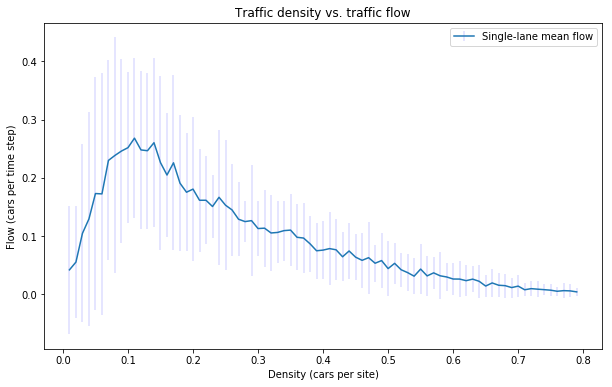

In [117]:
# plt.plot(traffic_density, total_flow, label='Single-lane mean flow', color='b')
plt.figure(figsize=(10,6))
plt.errorbar(traffic_density, total_flow, yerr=[1.96*sd for sd in sds],
             ecolor='b', elinewidth=0.2,label='Single-lane mean flow')
plt.xlabel('Density (cars per site)')
plt.ylabel('Flow (cars per time step)')
plt.legend()
plt.title('Traffic density vs. traffic flow')
plt.show()

In [118]:
# Two-lane CA

traffic_density = np.arange(0.01, 0.8, 0.01)
repetitions = 1000
num_sims = 30

total_flow_2 = []
sds_2 = []

for i in traffic_density: 
    flows_for_single_density = []
    
    for simulation in range (num_sims):
        count = [] 
        sim = TrafficSimulation(road_length=50, traffic_density=i,
                                num_lanes=2, max_velocity=5,p_of_slowing_down=0.5)
        sim.populate_cars()
        
        # These iterations will be "burned"
        # i.e., will not be counted towards the flow.
        for x in range(200):
            _ = sim.update()
        
        # These are iterations whose flows will be stored.
        for x in range(repetitions):
            count.append(sim.update())
    
        flows_for_single_density.append(sum(count)/(2*repetitions)) 
        
    total_flow_2.append(np.mean(flows_for_single_density))
    sds_2.append(np.std(flows_for_single_density))

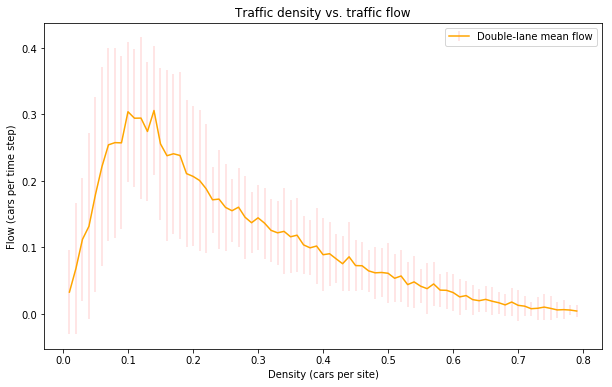

In [119]:
# plt.plot(traffic_density, total_flow_2, color='orange',label='Double-lane mean flow')
plt.figure(figsize=(10,6))
plt.errorbar(traffic_density, total_flow_2, yerr=[1.96*sd for sd in sds_2],
             ecolor='r', elinewidth=0.2, color='orange',label='Double-lane mean flow')
plt.xlabel('Density (cars per site)')
plt.ylabel('Flow (cars per time step)')
plt.legend()
plt.title('Traffic density vs. traffic flow')
plt.show()

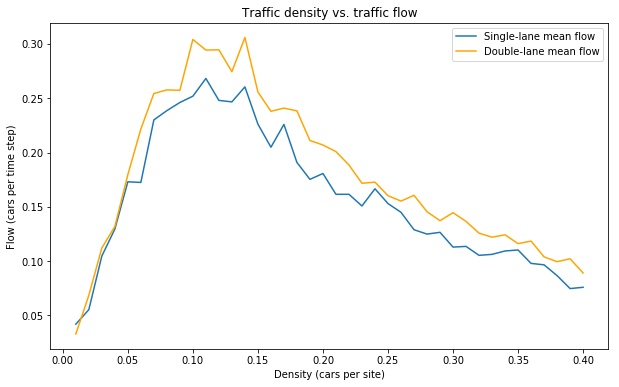

In [147]:
plt.figure(figsize=(10,6))
plt.plot(traffic_density[:40], total_flow[:40], label='Single-lane mean flow')
plt.plot(traffic_density[:40], total_flow_2[:40], color='orange',label='Double-lane mean flow')
plt.xlabel('Density (cars per site)')
plt.ylabel('Flow (cars per time step)')
plt.legend()
plt.title('Traffic density vs. traffic flow')
plt.show()

In [148]:
print('The peak flow in a single-lane model occurs at the following density: ',
      list(density for density, flow in zip(traffic_density, total_flow) if flow == max(total_flow)))
print('The peak flow in a double-lane model occurs at the following density: ',
      list(density for density, flow in zip(traffic_density, total_flow_2) if flow == max(total_flow_2)))

The peak flow in a single-lane model occurs at the following density:  [0.11]
The peak flow in a double-lane model occurs at the following density:  [0.14]
